In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from time import time
import matplotlib
import sklearn
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score
from sklearn.decomposition import PCA
tf.keras.backend.set_floatx('float64')
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from utilities import EdwinRueda_utils
%matplotlib inline
print("tensorflow version: ", tf.__version__)
print("numpy version: ", np.__version__)
print("matplotlib version: ", matplotlib.__version__)
print("sklearn version: ", sklearn.__version__)

tensorflow version:  2.2.0
numpy version:  1.18.1
matplotlib version:  3.1.1
sklearn version:  0.21.3


<center> <h1> Proposed Method - Baseline</h1>

<b>Autor:</b> Edwin Rueda <br>
<b>email:</b> ejrueda95g@gmail.com <br>
<b>github:</b> https://github.com/ejrueda <br>
<b>website:</b> http://edwinrueda.com/ <br>
<b> You can cite this work with</b>:

@software{edwin_rueda_2020_3843381,<br>
  author       = {Edwin Rueda},<br>
  title        = {ejrueda/MasterUFPA: zenodo release},<br>
  month        = may,<br>
  year         = 2020,<br>
  publisher    = {Zenodo},<br>
  version      = {zenodo},<br>
  doi          = {10.5281/zenodo.3843381},<br>
  url          = {https://doi.org/10.5281/zenodo.3843381}<br>
}

### Notes:
- for the baseline, we implemented a SMOTE algorithm instead of a GAN architecture to generate synthetic samples.

-----------------
Proposed Method
-----------------


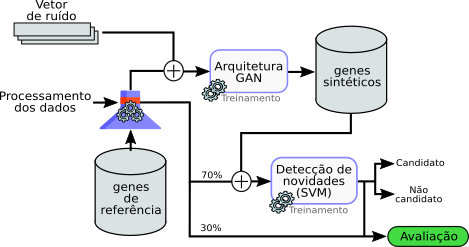

In [2]:
from PIL import Image
print("-----------------")
print("Proposed Method")
print("-----------------")
Image.open("../images/methodology_quali.png")

### Loading the preprocessed data
- Reference Genes are also loaded. Note: the <b>idnT</b> gene is not taken into account due to the high Coefficient of Variation of its gene expression.

In [3]:
data = pd.read_csv("../data/all_counts_9_norm_rpkm_log2_preprocessed.csv", index_col=0)
data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
aaeA,5.542667,5.876225,5.189101,6.178741,6.258982,5.921482,6.565341,6.308676,6.256590
aaeB,5.627977,5.436188,5.397088,5.493631,5.603751,5.716862,5.840627,6.132819,5.896502
aaeR,5.645506,5.758852,5.107190,5.824890,5.487705,6.033795,5.710782,6.302440,16.270368
aaeX,6.081770,6.043589,6.030808,6.358792,15.682419,6.129392,6.042647,6.134309,15.797839
aas,6.224669,6.297153,6.297008,6.047021,6.038410,6.296795,6.295251,6.598525,6.568365


In [4]:
rg = open("../data/reference_genes.txt").read().splitlines()
print(rg)

['cysG', 'hcaT', 'idnT', 'rrsA', 'ihfB', 'ssrA', 'gyrA', 'recA', 'rpoB', 'rpoA', 'gyrB', 'rho', 'ftsZ', 'secA', 'rpoC', 'gmk', 'adk', 'rpoD', 'dnaG', 'glnA', 'recF']


In [5]:
rg_data = data.reindex(rg).dropna()
rg_data

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,5.903687,5.879490,5.873191,5.735536,6.016590,6.328393,6.315338,6.504277,6.577601
hcaT,5.692781,5.733848,5.686571,5.925712,6.290692,6.131968,6.113390,5.891730,5.822536
rrsA,10.498560,10.775182,11.515848,11.819169,11.745607,11.033925,10.521316,8.685239,10.590185
ihfB,11.625723,11.784312,12.694811,13.119308,13.096534,12.574847,12.140031,10.126885,11.298441
ssrA,12.889916,13.026561,13.839784,14.807551,14.601034,13.858224,14.509441,12.713618,13.816964
gyrA,19.364537,19.544602,10.195372,19.601927,19.576949,18.693722,17.988391,16.700954,17.802523
recA,16.741059,16.808839,17.125494,11.214665,10.997956,10.271486,19.879175,18.190008,19.661178
rpoB,8.974988,19.071784,10.029701,19.552264,19.479836,18.539912,8.439041,16.884159,18.085799
rpoA,12.169900,12.425077,13.123721,12.536993,12.467720,11.604108,11.477677,19.684894,11.166540


### Scaling the data
- the data is scaled between -1 and 1 to facilitate the training of the GAN architecture

In [6]:
scaler = EdwinRueda_utils.scaler(xmin=-1, xmax=1)
scaler.fit(rg_data)
rg_data = scaler.transform(rg_data)
print("Reference genes scaled: ")
rg_data

Reference genes scaled: 


,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377
gyrA,1.000000,0.994874,-0.356674,1.000000,1.000000,0.909390,0.725292,0.567331,0.731382
recA,0.616219,0.599711,0.632131,-0.209725,-0.265305,-0.370792,1.000000,0.783242,1.000000
rpoB,-0.519856,0.926579,-0.380312,0.992837,0.985677,0.886011,-0.662111,0.593895,0.772322
rpoA,-0.052482,-0.033495,0.061149,-0.019001,-0.048531,-0.168233,-0.220635,1.000000,-0.227669


### Training the One-class classifier based on support vector machine
- <b>First</b>, we trained the proposed classifier based only on the initial data (without augmented the Reference genes set).
- <b>Notes:</b>
    - the selection of the hyperparameters of the classifier are based on the train and test data score.
    - cross-validation is used due the small number of samples.
    - the dataset is separated id two sets (70% to train the model and 30% to test the model), this split is random.

In [7]:
from sklearn.svm import OneClassSVM
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split

class ocsvm_utilities:
    """
    ocsvm_utilities class allows to train an one-class SVM with cross_validation
    and allows select the best initial parameters
    inputs:
        X: Dataframe with the RG to train the novelty detector. The index of this
           Dataframe must be the name of each gene.
        y: labels, for this aproach the target is a vector of ones with dimension
           equal to X.shape[0]
        test_size: the percentage of data to be used in the test step
        k_folds: the number of folds in the cross validation step
    """
    def __init__(self, X, y, test_size, k_folds):
        self.X = X
        self.y = y
        self.test_size = test_size
        self.k_folds = k_folds
        self.cv_results = {}
        
    def ocsvm_score(self,estimator, X, y):
        """
        this function compute the recall score obtained in a one-class classifier.
        this function is used as an argument in cross validation
        inputs:
            estimator: trained estimator
            X: test data
            y: target
        output:
            recall socore
        """
        tp, fn = sum(estimator.predict(X)==1), sum(estimator.predict(X)!=1)
        return  tp/(tp + fn)
    
    def get_best_params(self, param_grid, n_iter=5):
        """
        This function compute a GridSearchCV for different training sets
        inputs:
            n_iter: number of iterations of the GridSearchCV in different training sets
                    ex: the training set is divided in 70% to train and 30% to test. For
                    default, this selection is made five times, then, the GridSearchCV is
                    used five times.
            param_grid: dictionary with the name and values of the parameter to change.
                        ex: {"nu": [.2, .5, .7]}
        return:
        
        """
        self.train_score, self.test_score = pd.DataFrame(), pd.DataFrame()
        self.train_score["best_nu"] = np.zeros(len(param_grid["nu"]))
        self.test_score["best_nu"] = np.zeros(len(param_grid["nu"]))
        #set index
        self.train_score = self.train_score.set_index(param_grid["nu"])
        self.test_score = self.test_score.set_index(param_grid["nu"])
        count_cv = 0
        for i in range(n_iter):
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size)
            self.ocsvm = OneClassSVM(kernel="rbf", gamma="auto")
            self.gsCV = GridSearchCV(self.ocsvm, param_grid=param_grid, cv=self.k_folds,
                                     scoring=self.ocsvm_score, return_train_score=True, iid=False)
            self.gsCV.fit(X_train, y_train)
            #self.cv_results["iter_"+str(i)] = self.gsCV.cv_results_            
            for cv in range(self.k_folds):
                self.train_score["score_cv_"+str(count_cv)] = self.gsCV.cv_results_["split"+str(cv)+"_train_score"]
                self.test_score["score_cv_"+str(count_cv)] = self.gsCV.cv_results_["split"+str(cv)+"_test_score"]
                count_cv += 1
            self.train_score.loc[self.gsCV.best_params_["nu"], "best_nu"] += 1
            self.test_score.loc[self.gsCV.best_params_["nu"], "best_nu"] += 1
        return self.train_score, self.test_score
    
    def get_statistics(self, iterations):
        """
        this funtion computes the recall score n times in both training and test set.
        where n=iterations
        inputs:
            iterations: int. number of times that the classifier is trained and tested.
        outputs:
            train_recall_score = list with n score values in the training data. where n=iterations
            test_recall_score = list with n score values in the test data. where n=iterations
        """
        train_recall_score = []
        test_recall_score = []
        best_nu = self.test_score.where(self.test_score.best_nu==self.test_score.best_nu.max()).dropna()
        #si hay mas de uno, se selecciona el de menor desviación estandar
        if len(best_nu) > 1:
            best_nu_param = best_nu.iloc[0,1:].name
            best_std = best_nu.iloc[0,1:].std()
            for i in range(1,len(best_nu)):
                aux_std = best_nu.iloc[i,1:].std()
                if aux_std < best_std:
                    best_std = aux_std
                    best_nu_param = best_nu.iloc[i,1:].name
        else:
            best_nu_param = best_nu.index[0]
                
        for i in range(iterations):
            X_train, X_test, y_train, y_test = train_test_split(self.X, self.y, test_size=self.test_size)
            clf = OneClassSVM(kernel="rbf", gamma="auto", nu=best_nu_param)
            clf.fit(X_train, y_train)
            train_recall_score.append(self.ocsvm_score(clf, X_train, y_train))
            test_recall_score.append(self.ocsvm_score(clf, X_test, y_test))
            
        return train_recall_score, test_recall_score

In [9]:
num_folds = 4
num_iter = 15
obj = ocsvm_utilities(rg_data, np.ones(rg_data.shape[0]), test_size=.3, k_folds=num_folds)
nu_params = 30
params = {"nu":np.linspace(.001,0.5, nu_params)}
train_score, test_score = obj.get_best_params(params, n_iter=num_iter)

In [10]:
train_score.head()

,best_nu,score_cv_0,score_cv_1,score_cv_2,score_cv_3,score_cv_4,score_cv_5,score_cv_6,score_cv_7,score_cv_8,...,score_cv_50,score_cv_51,score_cv_52,score_cv_53,score_cv_54,score_cv_55,score_cv_56,score_cv_57,score_cv_58,score_cv_59
0.001000,5.0,0.7,0.6,0.636364,0.454545,0.7,0.7,0.454545,0.818182,0.6,...,0.454545,0.454545,0.7,0.4,0.727273,0.454545,0.5,0.4,0.363636,0.454545
0.018207,10.0,0.7,0.7,0.727273,0.636364,0.8,0.8,0.636364,0.818182,0.6,...,0.636364,0.545455,0.6,0.7,0.545455,0.727273,0.6,0.6,0.545455,0.545455
0.035414,0.0,0.7,0.7,0.818182,0.636364,0.7,0.6,0.636364,0.727273,0.7,...,0.818182,0.636364,0.6,0.8,0.636364,0.727273,0.9,0.5,0.727273,0.727273
0.052621,0.0,0.6,0.6,0.818182,0.545455,0.7,0.8,0.727273,0.818182,0.7,...,0.818182,0.636364,0.6,0.5,0.727273,0.727273,0.9,0.6,0.727273,0.636364
0.069828,0.0,0.6,0.6,0.818182,0.636364,0.7,0.8,0.727273,0.727273,0.7,...,0.636364,0.636364,0.6,0.8,0.818182,0.727273,0.8,0.5,0.727273,0.636364


In [11]:
best_nu = test_score.where(train_score.best_nu>=1).dropna()
best_nu

,best_nu,score_cv_0,score_cv_1,score_cv_2,score_cv_3,score_cv_4,score_cv_5,score_cv_6,score_cv_7,score_cv_8,...,score_cv_50,score_cv_51,score_cv_52,score_cv_53,score_cv_54,score_cv_55,score_cv_56,score_cv_57,score_cv_58,score_cv_59
0.001000,5.0,0.25,0.25,0.0,0.666667,0.25,0.75,0.333333,0.333333,0.5,...,0.333333,0.333333,0.25,0.75,0.0,0.666667,0.0,0.75,0.666667,0.333333
0.018207,10.0,0.25,0.50,0.0,0.666667,0.50,0.75,0.333333,0.333333,0.5,...,1.000000,0.333333,0.50,0.50,0.0,0.666667,0.0,0.50,0.666667,0.333333


In [12]:
best_nu_param = best_nu.where(best_nu.best_nu==best_nu.best_nu.max()).dropna().index[0]
best_nu_param

0.01820689655172414

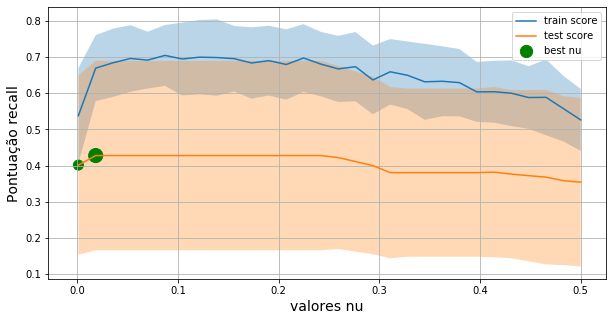

In [13]:
plt.figure(figsize=(10,5))
train_mean = train_score.iloc[:,1:].mean(axis=1).values
train_std = train_score.iloc[:,1:].std(axis=1)
plt.plot(train_score.index, train_mean, label="train score");
plt.fill_between(train_score.index, train_mean-train_std,
                train_mean+train_std, alpha=.3)

test_mean = test_score.iloc[:,1:].mean(axis=1).values
test_std = test_score.iloc[:,1:].std(axis=1)
plt.plot(test_score.index, test_mean, label="test score");
plt.fill_between(test_score.index, test_mean-test_std,
                test_mean+test_std, alpha=.3)

s = best_nu["best_nu"].values/best_nu["best_nu"].values.max()*200
plt.scatter(best_nu.index, best_nu.iloc[:,1:].mean(axis=1), s=s, label="best nu", color="green")

plt.legend()
plt.ylabel("Pontuação recall", fontsize=14)
plt.xlabel("valores nu", fontsize=14)
plt.grid();

#### training the model with the best param
- to visualizate the variation of the model with diferent initial data, we train the one-class classifier $n$ times and plot the boxplot.

In [14]:
train_recall_score, test_recall_score = obj.get_statistics(iterations=20)

In [15]:
bu = EdwinRueda_utils.bokeh_utils()
[lo_train, q25_train, q50_train, q75_train, up_train], otrain = bu.boxtplot_values(np.array(train_recall_score),
                                                                                  min_value=True, max_value=True)
[lo_test, q25_test, q50_test, q75_test, up_test], otest = bu.boxtplot_values(np.array(test_recall_score),
                                                                            min_value=True, max_value=True)

In [16]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.transform import jitter
from bokeh.models import ColumnDataSource
output_notebook()

Loading BokehJS ...

In [17]:
x_ticks = ["Train", "Test"]
p = figure(x_range=x_ticks, width=300, height=250, background_fill_color="#efefef")
#lower and upper rects
p.rect(x_ticks, [lo_train, lo_test], width=.12, height=.002, line_color="black")
p.rect(x_ticks, [up_train, up_test], width=.12, height=.002, line_color="black")
#segments
p.segment(x_ticks, [lo_train, lo_test], x_ticks, [q25_train, q25_test], line_color="black")
p.segment(x_ticks, [q75_train, q75_test], x_ticks, [up_train, up_test], line_color="black")
#vars
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q25_train, q25_test], line_color="black", fill_color="#E08E79")
p.vbar(x_ticks, 0.35, [q50_train, q50_test], [q75_train, q75_test], line_color="black", fill_color="#3B8686")
p.xaxis.axis_label = "conjunto de dados"
p.yaxis.axis_label = "pontuação recall"
p.xgrid.grid_line_color = None
p.ygrid.grid_line_color = "white"
show(p)

### Baseline with the SMOTE algorithm
- We augment the original dataset with different percentages and select the percentage that presents the best and most stable score.

In [18]:
smote = EdwinRueda_utils.smote()

In [19]:
rg_data.head()

,BB9,BB10,BB17,BB19,BB20,BB21,BB11,BB12,BB18
gene,,,,,,,,,
cysG,-0.969147,-0.978963,-0.973373,-1.000000,-1.000000,-0.970143,-0.970659,-0.911181,-0.890876
hcaT,-1.000000,-1.000000,-1.000000,-0.972570,-0.959573,-1.000000,-1.000000,-1.000000,-1.000000
rrsA,-0.296977,-0.271812,-0.168266,-0.122535,-0.155035,-0.254901,-0.359582,-0.594943,-0.310966
ihfB,-0.132088,-0.126050,-0.000049,0.064988,0.044212,-0.020681,-0.124403,-0.385905,-0.208607
ssrA,0.052847,0.053385,0.163319,0.308490,0.266109,0.174393,0.219843,-0.010831,0.155377


#### generating synthetic reference genes with the SMOTE algorithm

In [20]:
percent = 100
synthetic_genes = smote.get_syn_samples(rg_data.values, percent, k=3)
synthetic_genes.shape

(20, 9)

In [21]:
pca = PCA(n_components=2)
rg_pca = pca.fit_transform(rg_data)
synt_pca = pca.transform(synthetic_genes)
rg_pca.shape, synt_pca.shape

((20, 2), (20, 2))

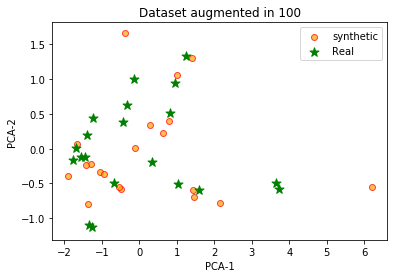

In [22]:
plt.scatter(synt_pca[:,0], synt_pca[:,1], alpha=.7, color="orange", edgecolor="red", label="synthetic")
plt.scatter(rg_pca[:,0], rg_pca[:,1], marker="*", s=90, color="green", label="Real")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.title("Dataset augmented in "+ str(percent))
plt.legend();

#### Analysis of the synthetic genes

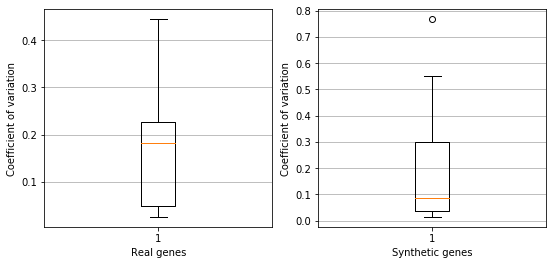

In [23]:
plt.figure(figsize=(9,4))
plt.subplot(1,2,1)
rg = scaler.inverse_transform(rg_data)
plt.boxplot(rg.std(axis=1)/rg.mean(axis=1))
plt.grid(axis="y")
plt.xlabel("Real genes")
plt.ylabel("Coefficient of variation");
plt.subplot(1,2,2)
synthetic_genes = smote.get_syn_samples(rg_data.values, 300, k=3)
syn = scaler.inverse_transform(synthetic_genes)
plt.boxplot(syn.std(axis=1)/syn.mean(axis=1));
plt.grid(axis="y")
plt.xlabel("Synthetic genes")
plt.ylabel("Coefficient of variation");

### Disadvantage of the SMOTE algorithm
- the smote algorithm does not create new samples, only modified existing samples.
- for this case, the synthetic genes presented a high value of the coefficient of variation.

In [24]:
percentages = np.arange(25, 1000, 25)
percentages

array([ 25,  50,  75, 100, 125, 150, 175, 200, 225, 250, 275, 300, 325,
       350, 375, 400, 425, 450, 475, 500, 525, 550, 575, 600, 625, 650,
       675, 700, 725, 750, 775, 800, 825, 850, 875, 900, 925, 950, 975])

In [25]:
num_folds = 4
num_iter = 15
train_mean_score_p = []
train_std_score_p = []
test_mean_score_p = []
test_std_score_p = []
for p in percentages:
    tic = time()
    synthetic_genes = smote.get_syn_samples(np.array(rg_data), p, k=3)
    augmented_data = np.concatenate((rg_data, synthetic_genes), axis=0)
    obj = EdwinRueda_utils.ocsvm_utilities(augmented_data, np.ones(augmented_data.shape[0]),
                                           test_size=.3, k_folds=num_folds)
    nu_params = 30
    params = {"nu":np.linspace(.001,0.5, nu_params)}
    train_score, test_score = obj.get_best_params(params, n_iter=num_iter)
    train_recall_score, test_recall_score = obj.get_statistics(iterations=30)
    #train params
    train_mean_score_p.append(np.mean(np.array(train_recall_score)))
    train_std_score_p.append(np.std(np.array(train_recall_score)))
    #test params
    test_mean_score_p.append(np.mean(np.array(test_recall_score)))
    test_std_score_p.append(np.std(np.array(test_recall_score)))
    toc = time()
    print("{} : time: {} [s]".format(p, toc-tic))

25 : time: 2.322751760482788
50 : time: 2.177133798599243
75 : time: 2.205892324447632
100 : time: 2.268637180328369
125 : time: 2.256169080734253
150 : time: 2.2437257766723633
175 : time: 2.2807865142822266
200 : time: 2.4468135833740234
225 : time: 2.4488401412963867
250 : time: 2.4182019233703613
275 : time: 2.450684070587158
300 : time: 2.648033857345581
325 : time: 2.647064208984375
350 : time: 2.6478967666625977
375 : time: 2.626478910446167
400 : time: 2.8798019886016846
425 : time: 2.8709444999694824
450 : time: 2.881558895111084
475 : time: 2.874526262283325
500 : time: 3.3243138790130615
525 : time: 3.3839621543884277
550 : time: 3.0929160118103027
575 : time: 3.1095027923583984
600 : time: 3.3849055767059326
625 : time: 3.824538469314575
650 : time: 3.3833584785461426
675 : time: 3.5017776489257812
700 : time: 4.031065225601196
725 : time: 3.772596836090088
750 : time: 3.7958686351776123
775 : time: 4.000253677368164
800 : time: 4.482633590698242
825 : time: 4.2474076747894

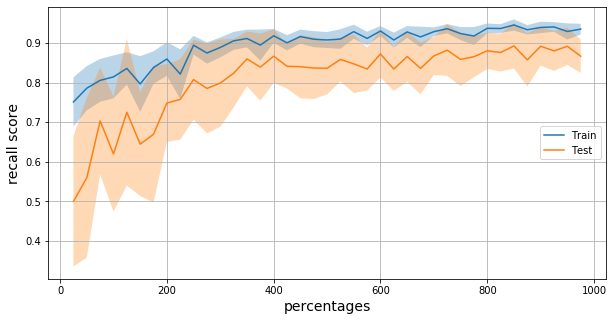

In [26]:
plt.figure(figsize=(10,5))
plt.plot(percentages, train_mean_score_p, label="Train");
plt.fill_between(percentages, np.array(train_mean_score_p)-np.array(train_std_score_p),
                np.array(train_mean_score_p)+np.array(train_std_score_p), alpha=.3)
#test results
plt.plot(percentages, test_mean_score_p, label="Test")
plt.fill_between(percentages, np.array(test_mean_score_p)-np.array(test_std_score_p),
                np.array(test_mean_score_p)+np.array(test_std_score_p), alpha=.3)
plt.grid()
plt.ylabel("recall score", fontsize=14)
plt.xlabel("percentages", fontsize=14)
plt.legend(loc="center right");